Saving im01.png to im01.png
Image loaded: im01.png
SSD (Nearest): 0.03021
SSD (Bilinear): 0.01068


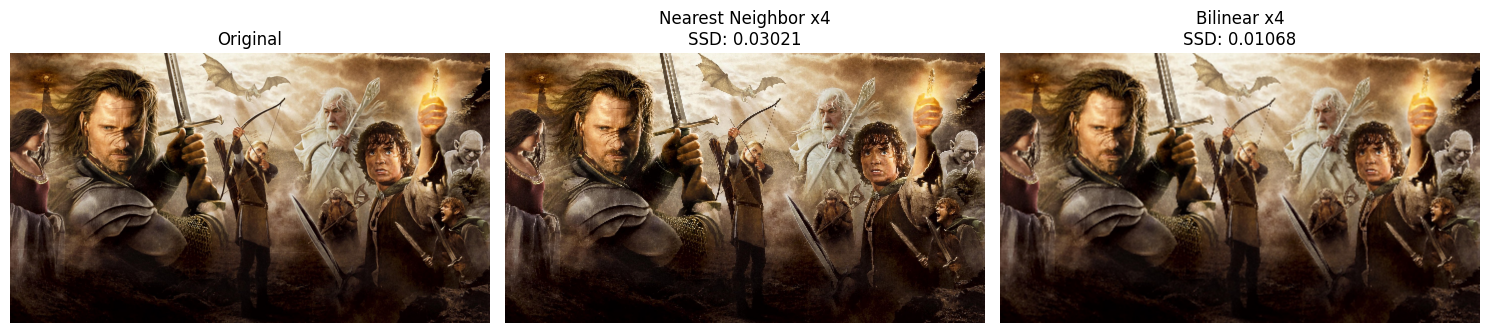

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload image
uploaded = files.upload()
img_name = list(uploaded.keys())[0]
img = cv.imread(img_name)

if img is None:
    print("Error: Image not loaded")
    exit()

print("Image loaded:", img_name)


# Nearest Neighbor Zoom
def nearest_neighbor_zoom(img, scale):
    h, w = img.shape[:2]
    new_h, new_w = int(h * scale), int(w * scale)

    x_new = np.arange(new_w)
    y_new = np.arange(new_h)

    x_old = (x_new / scale).astype(int)
    y_old = (y_new / scale).astype(int)

    x_old = np.clip(x_old, 0, w - 1)
    y_old = np.clip(y_old, 0, h - 1)

    xv, yv = np.meshgrid(x_old, y_old)
    return img[yv, xv]

# Bilinear Zoom
def bilinear_zoom(img, scale):
    h, w = img.shape[:2]
    new_h, new_w = int(h * scale), int(w * scale)

    x_src = np.arange(new_w) / scale
    y_src = np.arange(new_h) / scale
    x_grid, y_grid = np.meshgrid(x_src, y_src)

    x1 = np.floor(x_grid).astype(int)
    y1 = np.floor(y_grid).astype(int)
    x2 = np.clip(x1 + 1, 0, w - 1)
    y2 = np.clip(y1 + 1, 0, h - 1)

    x1 = np.clip(x1, 0, w - 1)
    y1 = np.clip(y1, 0, h - 1)

    alpha = x_grid - x1
    beta = y_grid - y1

    if img.ndim == 3:
        alpha = alpha[..., None]
        beta = beta[..., None]

    A = img[y1, x1]
    B = img[y1, x2]
    C = img[y2, x1]
    D = img[y2, x2]

    top = (1 - alpha) * A + alpha * B
    bottom = (1 - alpha) * C + alpha * D
    final = (1 - beta) * top + beta * bottom

    return final.astype(np.uint8)

# SSD Function
def compute_ssd(img1, img2):
    h = min(img1.shape[0], img2.shape[0])
    w = min(img1.shape[1], img2.shape[1])

    img1 = img1[:h, :w]
    img2 = img2[:h, :w]

    diff = img1.astype(float) - img2.astype(float)
    return np.sum(diff ** 2) / np.sum(img1.astype(float) ** 2)

# Create small image
small = cv.resize(img, None, fx=0.25, fy=0.25, interpolation=cv.INTER_NEAREST)

# Zoom back x4
zoom_nn = nearest_neighbor_zoom(small, 4)
zoom_bl = bilinear_zoom(small, 4)


 # Compare (SSD)
ssd_nn = compute_ssd(img, zoom_nn)
ssd_bl = compute_ssd(img, zoom_bl)

print(f"SSD (Nearest): {ssd_nn:.5f}")
print(f"SSD (Bilinear): {ssd_bl:.5f}")

# Show results
plt.figure(figsize=(15, 6))

 # Original
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

 # Nearest Neighbor
plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(zoom_nn, cv.COLOR_BGR2RGB))
plt.title(f"Nearest Neighbor x4\nSSD: {ssd_nn:.5f}")
plt.axis("off")

  # Bilinear
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(zoom_bl, cv.COLOR_BGR2RGB))
plt.title(f"Bilinear x4\nSSD: {ssd_bl:.5f}")
plt.axis("off")

plt.tight_layout()
plt.show()